# Fit S(Q)

In [1]:
# Chi-Huan Tung
# National Tsing-Hua University
# Aug 2021
#
# Fit the I(Q) curve using the S(Q) generated by pre-trained cVAE model
# Infer potential parameters from optimized latent variables using GPR
# tensorflow 2.6.0
# sklearn 0.24.2

## Setup

In [2]:
fit_SQ = 0

In [3]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import scipy.interpolate as interp
tf.config.run_functions_eagerly(True)

Assign device (GPU)

In [4]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Load data

### Training set

In [6]:
# minimum sq
sq_min = np.exp(-5)

In [7]:
if 1:
    X_file = '../data/input_grid_all_GPR80.csv'
    Y_file = '../data/target_grid_all.csv'
else:
    X_file = '../data/input_random_all_GPR80.csv'
    Y_file = '../data/target_random_all.csv'
    
fX = open(X_file, 'r', encoding='utf-8-sig')
sq = np.genfromtxt(fX, delimiter=',').astype(np.float32)
sq[sq<=0] = sq_min

fY = open(Y_file, 'r', encoding='utf-8-sig')
target = np.genfromtxt(fY, delimiter=',').astype(np.float32)

In [8]:
if 0:
    sq = np.vstack((sq[0:7500,:],sq))
    target = np.vstack((target[0:7500,:],target))

In [9]:
sq.shape

(18750, 80)

In [10]:
eta = target[:,0]
kappa = target[:,1]
Z = target[:,3]
A = target[:,2]
lnZ = np.log(Z)
lnA = np.log(A)

In [11]:
sq_dim = sq.shape[1]
sample_train_dim = sq.shape[0]

$Q\cdot r_\textrm{ave}$

In [12]:
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2
q_rs_dim = q_rs.shape[0]

Rescale

In [13]:
r_eta = 1
sq_rs = np.zeros((sample_train_dim,q_rs_dim),dtype='float32')
for i in range(sample_train_dim):
    qr_eta = q*r_eta
    interpolating_function = interp.interp1d(qr_eta[3:],sq[i,3:],fill_value='extrapolate')
    sq_rs[i,:] = interpolating_function(q_rs).astype(np.float32)
sq_rs[sq_rs<=0] = sq_min

### Test set

In [14]:
# minimum sq
sq_min = np.exp(-5)

In [15]:
if 1:
    X_file = '../data/input_grid_all_GPR80.csv'
    Y_file = '../data/target_grid_all.csv'
else:
    X_file = '../data/input_random_all_GPR80.csv'
    Y_file = '../data/target_random_all.csv'
    
fX_test = open(X_file, 'r', encoding='utf-8-sig')
sq_test = np.genfromtxt(fX_test, delimiter=',').astype(np.float32)
sq_test[sq_test<=0] = sq_min

fY_test = open(Y_file, 'r', encoding='utf-8-sig')
target_test = np.genfromtxt(fY_test, delimiter=',').astype(np.float32)

In [16]:
sq_test.shape

(18750, 80)

In [17]:
eta_test = target_test[:, 0]
kappa_test = target_test[:, 1]
Z_test = target_test[:, 3]
A_test = target_test[:, 2]
lnZ_test = np.log(Z_test)
lnA_test = np.log(A_test)

In [18]:
sq_dim = sq_test.shape[1]
sample_test_dim = sq_test.shape[0]

$Q\cdot r_\textrm{ave}$

In [19]:
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2
q_rs_dim = q_rs.shape[0]

Rescale

In [20]:
r_eta_test = 1
sq_test_rs = np.zeros((sample_test_dim,q_rs_dim),dtype='float32')
for i in range(sample_test_dim):
    qr_eta = q*r_eta_test
    interpolating_function_test = interp.interp1d(qr_eta[3:],sq_test[i,3:],
                                                  fill_value='extrapolate',kind='linear')
    sq_test_rs[i,:] = interpolating_function_test(q_rs)
sq_test_rs[sq_test_rs<=0] = sq_min

### Mask

In [21]:
mask_length = 0
sq_mask = sq_rs
sq_test_mask = sq_test_rs

for i in range(sample_train_dim):
    sq_mask[i,0:mask_length] = sq_rs[i,mask_length]
for i in range(sample_test_dim):
    sq_test_mask[i,0:mask_length] = sq_test_mask[i,mask_length]

### Preprocess/Postprocess

In [22]:
exp_scale = 6

def f_inp(sq):
    return np.log(sq)/exp_scale/2 + 0.5

def f_out(predictions):
    return np.exp((predictions*2-1)*exp_scale)

## Network architecture

In [23]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, sq_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        regularizer = None
        self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(sq_dim)),
            tf.keras.layers.Reshape((sq_dim,1)),
            tf.keras.layers.Conv1D(
                filters=32, kernel_size=3, strides=2, activation='relu',
                kernel_regularizer = regularizer,
                name='conv1d_en'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(
                latent_dim + latent_dim, 
                kernel_regularizer = regularizer,
                name='dense_en'),
        ]
        )
        
        self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(
                40*32, activation=tf.nn.relu, 
                kernel_regularizer = regularizer,
                name='dense_de'),
            tf.keras.layers.Reshape(target_shape=(40, 32)),
            tf.keras.layers.Conv1DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same', activation='relu',
                kernel_regularizer = regularizer,
                name='conv1dtrs_de'),
            tf.keras.layers.Conv1DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
            tf.keras.layers.Reshape((sq_dim,))
        ]
        )
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = 0*tf.random.normal(shape=(1000, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
        
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [24]:
latent_dim = 3
model = VAE(latent_dim, q_rs_dim)

## Load trained model

In [25]:
export_path = './saved_model/SQ_cVAE_MSE_ns/'
model_name = 'model_conv_stride2_exp6'
export_name = export_path + model_name

In [26]:
reload_sm = model.load_weights(export_name, by_name=False, skip_mismatch=False, options=None)
reload_sm.__dict__

{'_checkpoint': <tensorflow.python.training.tracking.util._CheckpointRestoreCoordinator at 0x2200dee20a0>,
 '_feed_dict': None,
 '_graph_view': <tensorflow.python.training.tracking.graph_view.ObjectGraphView at 0x2200c3b7ee0>,
 '_root': <__main__.VAE at 0x2200c3a8e80>}

In [27]:
model_r = reload_sm._root
#model_r.__dict__

### Loaded network architecture

In [28]:
class VAE_r():
    def __init__(self):
        self.encoder = model_r.encoder
        self.decoder = model_r.decoder
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(1000, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
        
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
M = VAE_r() # loaded model

In [29]:
def decoder_mean(model,lv):
    x = model.sample(lv)
    
    return x

def encoder_mean(model,x):
    mean = model.encode(x)[0]
    
    return mean

## Define functions 

In [30]:
exp_scale = 6

@tf.function
def f_inp_tf(sq):
    return tf.math.log(sq)/exp_scale/2 + 0.5

@tf.function
def f_out_tf(predictions):
    return tf.math.exp((predictions*2-1)*exp_scale)

In [31]:
def to_tf(arg):
    arg = tf.convert_to_tensor(arg, dtype=tf.float32)
    return arg

In [32]:
def hardsphere(q,sigma=1):
    R = to_tf(sigma/2)
    P = (3*(tf.math.sin(q*R)-q*R*tf.math.cos(q*R))/(q*R)**3)**2
    return P
    
    
def interpolation_tf(q,x,scale):
    qs = q*scale
    x_interp = tfp.math.interp_regular_1d_grid(
        to_tf(qs), tf.math.reduce_min(to_tf(q)), tf.math.reduce_max(to_tf(q)), x)
    return x_interp

def SQ_th(model, fp):
    # structure factor
    lv = tf.reshape(to_tf(fp[0:3]),(1,3))
    x_logit = decoder_mean(model,lv)
    S = f_out_tf(x_logit)
    
    # interpolation
    #S_interp = interpolation_tf(q,S,fp[3])
    
    return S

def IQ_th(model, fp):
    # form factor
    P = hardsphere(q,fp[3])
    
    # structure factor
    lv = tf.reshape(to_tf(fp[0:3]),(1,3))
    x_logit = decoder_mean(model,lv)
    S = f_out_tf(x_logit)
    
    # I(Q)
    if fit_SQ==1:
        IQ_th = S
    else:
        IQ_th = S*P
    
    # interpolation
    IQ_th_interp = interpolation_tf(q,IQ_th,fp[3])
    return IQ_th_interp

def fit_loss(model, x, fp):
    x_th = IQ_th(model, fp)
    
    # mean-square error
    err = tf.reduce_mean((tf.math.log(x_th)-tf.math.log(x))**2)
    
    return err

In [33]:
@tf.function
def train_step(model, x, fp, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = fit_loss(model, x, fp)
    gradients = tape.gradient(loss, fp)
    optimizer.apply_gradients(zip(gradients, fp))

In [34]:
from scipy import interpolate
def generate_image(model, IQ_exp, fp, epoch=0):
    error = fit_loss(model, IQ_exp, fp)
    IQ_th_current = IQ_th(model, fp)[0,:]
    
    #display.clear_output(wait=False)
    
    fig = plt.figure(figsize=(8, 6))
    ax = plt.subplot(1, 1, 1)
    
    plt.plot(q,IQ_exp,'sk')
    #plt.plot(q,IQ_th_current,'b')
    
    q_new = np.logspace(np.log10(0.2),np.log10(16),500)
    spl = interpolate.InterpolatedUnivariateSpline(q,IQ_th_current)
    IQ_th_new = spl(q_new)
    
    plt.plot(q_new,IQ_th_new,'b')
    
    fp_s = (np.matmul([fp[0:3],]-z_mean,U)*sgn)[0]
    
    plt.text(0.8,0.96,'MSE = {:.2e}'.format(error),transform=ax.transAxes)
    #plt.text(0.8,0.96,'lv[0] = {:+.2f}'.format(fp_s[0]),transform=ax.transAxes)
    #plt.text(0.8,0.90,'lv[1] = {:+.2f}'.format(fp_s[1]),transform=ax.transAxes)
    #plt.text(0.8,0.84,'lv[2] = {:+.2f}'.format(fp_s[2]),transform=ax.transAxes)
    #plt.text(0.8,0.78,'$\sigma$ = {:+.2f}'.format(fp[3].numpy()),transform=ax.transAxes)
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlim(3, 16)
    #plt.ylim(3e-4, 0.3)
    plt.xlabel('$Q$')
    plt.ylabel('$I(Q)$')
    
    pngname = './figures_SQ_cVAE_MSE_ns/fit/fit_{:04d}.png'
    plt.savefig(pngname.format(epoch))
    plt.close()
    #plt.show()
    #print('epoch = {:04d}'.format(epoch))
    #time.sleep(0.1)

## Pick an I(Q) and test

In [35]:
index_test = 16609 #9202
sigma_test = 1.00
SQ_exp = sq_test_mask[index_test,:]
lv_GT = encoder_mean(M,to_tf(f_inp(SQ_exp.reshape((1,80)))))

SQ_exp = to_tf(SQ_exp)
P = hardsphere(q,1)

if fit_SQ==1:
    IQ_exp = SQ_exp
else:
    IQ_exp = SQ_exp*P
    
IQ_exp = interpolation_tf(q,IQ_exp,sigma_test)

fp_GT = [lv_GT[0,0],lv_GT[0,1],lv_GT[0,2],to_tf(sigma_test)]

### Initial value

In [36]:
with np.load(export_path +'lv_SVD_exp6.npz') as data:
    z_mean = data['z_mean']
    U = data['U']
    sgn = data['sgn']

In [37]:
# tf.constant("Initial Guess")
def initial_guess_transform(lv_s = [-1,0,1]):
    lv = to_tf(np.matmul(lv_s*sgn,U.T) + z_mean)
    return lv

sigma_i = tf.constant(1.00)
lv0_i = tf.constant(initial_guess_transform()[0])
lv1_i = tf.constant(initial_guess_transform()[1])
lv2_i = tf.constant(initial_guess_transform()[2])

# constraint=lambda t: tf.clip_by_value(t, "Lower Bound", "Upper Bound")
sigma = tf.Variable(sigma_i, name='sigma', dtype=tf.float32, 
                    constraint=lambda t: tf.clip_by_value(t, 1.0, 1.0))
lv0 = tf.Variable(lv0_i, name='lv0', dtype=tf.float32, 
                 constraint=lambda t: tf.clip_by_value(t, -10, 10))
lv1 = tf.Variable(lv1_i, name='lv1', dtype=tf.float32, 
                 constraint=lambda t: tf.clip_by_value(t, -10, 10))
lv2 = tf.Variable(lv2_i, name='lv2', dtype=tf.float32, 
                 constraint=lambda t: tf.clip_by_value(t, -10, 10))

fp = [lv0,lv1,lv2,sigma]

---
### Fit

In [38]:
generate_image(M, IQ_exp, fp)
epochs = 200

import progressbar
bar = progressbar.ProgressBar(maxval=epochs, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()

optimizer = tf.keras.optimizers.Adam(0.1)
start_time = time.time()

fp_epoch = []
for epoch in range(1, epochs + 1):
    train_step(M, IQ_exp, fp, optimizer)
    
    bar.update(epoch)
    #sleep(0.1)
    
    # generate image
    if 1:
        if epoch%4 == 0:
            generate_image(M, IQ_exp, fp, epoch)
    
    fp_current = [fp[0].numpy(),fp[1].numpy(),fp[2].numpy(),fp[3].numpy()]
    fp_epoch.append(fp_current)

end_time = time.time()
bar.finish()

print('time elapsed = {:0.2f}s'.format(end_time - start_time))

time elapsed = 16.52s


### Display animated GIF


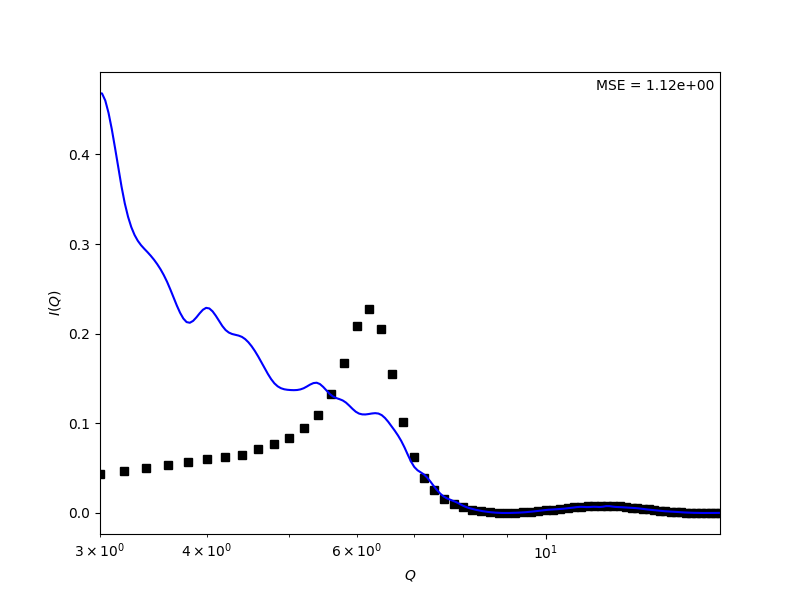

In [39]:
anim_file = './figures_SQ_cVAE_MSE_ns/fit/fit.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./figures_SQ_cVAE_MSE_ns/fit/fit_*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

---

### fitting parameters summary

In [40]:
fp_s = (np.matmul([fp[0:3],]-z_mean,U)*sgn)[0]
fp_GT_s = (np.matmul([fp_GT[0:3],]-z_mean,U)*sgn)[0]

In [41]:
string_fp    = 'fp      = {:0.4f}, {:0.4f}, {:0.4f}\n'.format(fp[0].numpy(),fp[1].numpy(),fp[2].numpy())
string_fp_GT = 'fp_GT   = {:0.4f}, {:0.4f}, {:0.4f}\n'.format(fp_GT[0].numpy(),fp_GT[1].numpy(),fp_GT[2].numpy())
string_fp_s    = 'fp_s    = {:0.4f}, {:0.4f}, {:0.4f}\n'.format(fp_s[0],fp_s[1],fp_s[2])
string_fp_GT_s = 'fp_GT_s = {:0.4f}, {:0.4f}, {:0.4f}\n'.format(fp_GT_s[0],fp_GT_s[1],fp_GT_s[2])
print(string_fp + string_fp_GT + string_fp_s + string_fp_GT_s)

fp      = -1.5770, 0.9161, -0.3360
fp_GT   = -1.5770, 0.9143, -0.3320
fp_s    = 1.4164, -0.4466, -0.0313
fp_GT_s = 1.4136, -0.4496, -0.0298



## Test GPR model

### load trained GPR model

In [42]:
parameters = (eta_test,kappa_test,lnA_test)
parameters_GP = np.vstack(parameters).T
index_eta = np.arange(sq_test.shape[0])

parameters_GT = parameters_GP[index_test,:]

In [43]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import joblib

In [44]:
export_path_GPR = './saved_model/GPR/' 
model_name_GPR_eta = 'sklearn/SQ_GPR_eta'
model_name_GPR_kappa = 'sklearn/SQ_GPR_kappa'
model_name_GPR_lnA = 'sklearn/SQ_GPR_lnA'
export_name_GPR_eta = export_path_GPR + model_name_GPR_eta
export_name_GPR_kappa = export_path_GPR + model_name_GPR_kappa
export_name_GPR_lnA = export_path_GPR + model_name_GPR_lnA
gp_eta = joblib.load(export_name_GPR_eta)
gp_kappa = joblib.load(export_name_GPR_kappa)
gp_lnA = joblib.load(export_name_GPR_lnA)

In [45]:
predict_eta = gp_eta.predict(SQ_th(M, fp).numpy(), return_std=True)
predict_kappa = gp_kappa.predict(SQ_th(model, fp).numpy(), return_std=True)
predict_lnA = gp_lnA.predict(SQ_th(M, fp).numpy(), return_std=True)
parameters_predict = [predict_eta,predict_kappa,predict_lnA]

In [46]:
print('Ground truth: \n--- eta = {:0.4f} \n--- kappa = {:0.4f} \n--- lnA = {:0.4f}\n'
      .format(parameters_GT[0],parameters_GT[1],parameters_GT[2]))
print('Predictions: \n--- eta = {:0.4f} +- {:0.4f} \n--- kappa = {:0.4f} +- {:0.4f} \n--- lnA = {:0.4f} +- {:0.4f}'
      .format(parameters_predict[0][0][0],parameters_predict[0][1][0],
              parameters_predict[1][0][0],parameters_predict[1][1][0],
              parameters_predict[2][0][0],parameters_predict[2][1][0]))

Ground truth: 
--- eta = 0.4050 
--- kappa = 0.3000 
--- lnA = 2.3026

Predictions: 
--- eta = 0.4014 +- 0.0005 
--- kappa = 0.2935 +- 0.0185 
--- lnA = 2.2098 +- 0.2039


### $V(r)$  
Sample $V(r)$ and determine the confidence interval

In [47]:
def sample_potential(parameters_predict,r,ur_hc):
    n_sample = 100
    kappa = parameters_predict[1][0][0]
    kappa_std = parameters_predict[1][1][0]
    lnA = parameters_predict[2][0][0]
    lnA_std = parameters_predict[2][1][0]
    
    ur_sample = np.zeros((tf.size(r),n_sample))
    for i in range(n_sample):
        kappa_sample = np.random.normal()*(kappa_std) + kappa
        lnA_sample = np.random.normal()*(lnA_std) + lnA
        ur_sample[:,i] = np.exp(lnA_sample)*np.exp(-(r-1)/kappa_sample)/r + ur_hc
        
    return ur_sample

In [48]:
r = np.linspace(0.01, 2.0, 200)
ur_hc = 4*500*((2**(1/6)/r)**12-(2**(1/6)/r)**6-0.25)
ur_hc[r>=1] = 0

ur_GT = np.exp(parameters_GT[2])*np.exp(-(r-1.0)/parameters_GT[1])/r + ur_hc
ur_predict = np.exp(parameters_predict[2][0][0])*np.exp(-(r-1.0)/parameters_predict[1][0][0])/r + ur_hc
ur_sample = sample_potential(parameters_predict,r,ur_hc)

ur_std = np.std(ur_sample,axis=1)
ur_mean = np.mean(ur_sample,axis=1)

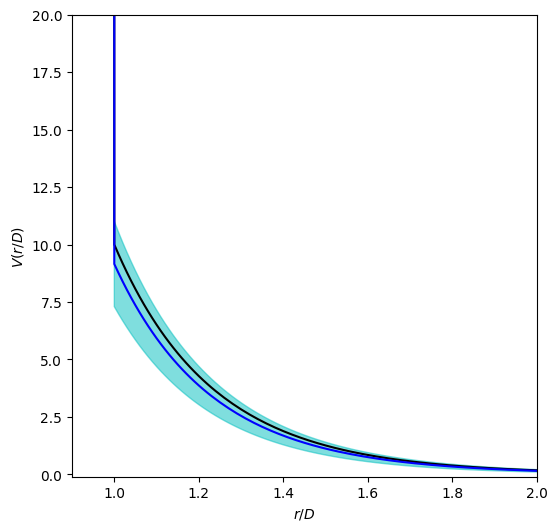

In [49]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.fill_between(r,ur_mean+ur_std,ur_mean-ur_std,color='c',alpha=0.5)
ax.plot(r,ur_GT,'k')
ax.plot(r,ur_mean,'b')
ax.set_xlim(0.9,2.0)
ax.set_ylim(-0.1,20)
ax.set_xlabel(r'$r/D$')
ax.set_ylabel(r'$V(r/D)$')
plt.show()

### Optimization

In [50]:
x = to_tf(f_inp(sq_mask))
mean, logvar = model.encode(x)
z = model.reparameterize(mean, logvar)
x_logit = model.sample(z)
z = z.numpy()
zc = z-z_mean
F = zc.T
zs = np.matmul(zc,U)*sgn

In [51]:
from scipy.spatial import ConvexHull
hull = ConvexHull(zs)

In [52]:
d_zs = np.max(zs,axis = 0)-np.min(zs,axis = 0)
d_z = np.max(z,axis = 0)-np.min(z,axis = 0)

In [53]:
parameters = (eta,kappa,lnA)
index_eta = np.arange(sq.shape[0])

In [54]:
#%matplotlib notebook

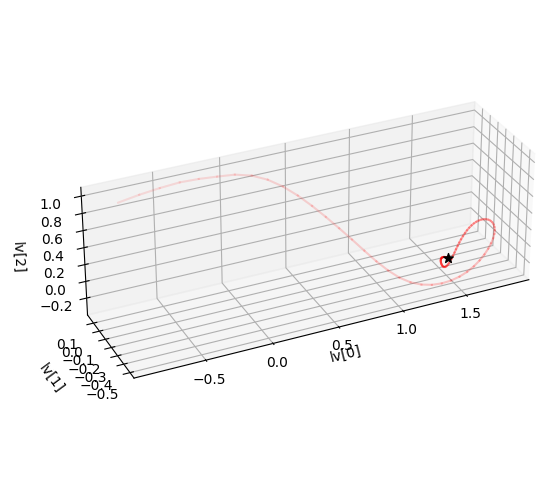

In [55]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
#ax.scatter(zs[index_eta,0], zs[index_eta,1], zs[index_eta,2], 
           #c=parameters[0][index_eta],
           #s=1)
        
#for s in hull.simplices:
    #s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    #ax.plot(zs[s, 0], zs[s, 1], zs[s, 2], "k-", alpha=0.1)

for i in range(len(fp_epoch)):
    if i==0:
        continue
        
    lv_i = fp_epoch[i][0:3]
    lv_i_s = (np.matmul([lv_i,]-z_mean,U)*sgn)[0]
    lv_ip = fp_epoch[i-1][0:3]
    lv_ip_s = (np.matmul([lv_ip,]-z_mean,U)*sgn)[0]
    
    alpha0 = 0.1
    ax.plot([lv_ip_s[0],lv_i_s[0]], [lv_ip_s[1],lv_i_s[1]], [lv_ip_s[2],lv_i_s[2]],
            '-r',alpha=alpha0+(1-alpha0)*(i/len(fp_epoch)))

ax.scatter(fp_GT_s[0], fp_GT_s[1], fp_GT_s[2], 
        c='k',
        s=50,
        marker='*')

ax.view_init(elev=30, azim=-115)
ax.set_xlabel('lv[0]')
ax.set_ylabel('lv[1]')
ax.set_zlabel('lv[2]')
ax.set_box_aspect([d_zs[0],d_zs[1],d_zs[2]])

scatter_name = './figures_SQ_cVAE_MSE_ns/lvsc3D_eta.png'
plt.savefig(scatter_name.format(epoch))
plt.show()

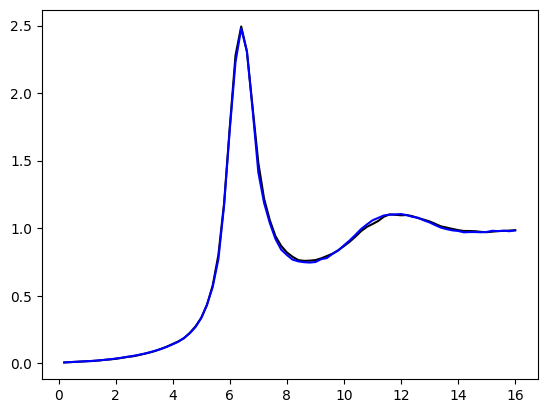

In [56]:
plt.plot(q,SQ_exp.numpy().reshape(80),'-k')
plt.plot(q,SQ_th(M, fp).numpy().reshape(80),'-b')

plt.show()

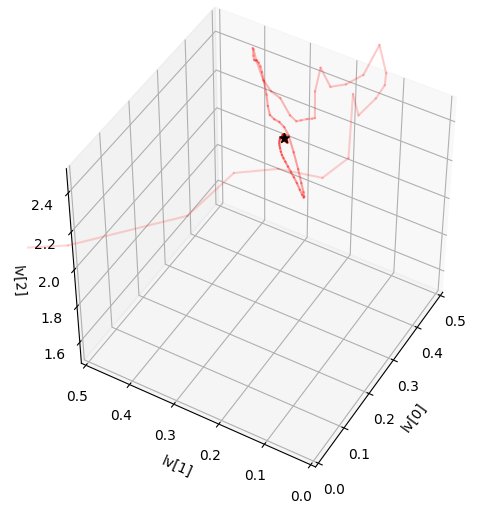

In [57]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
#ax.scatter(zs[index_eta,0], zs[index_eta,1], zs[index_eta,2], 
           #c=parameters[0][index_eta],
           #s=1)
        
#for s in hull.simplices:
    #s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    #ax.plot(zs[s, 0], zs[s, 1], zs[s, 2], "k-", alpha=0.1)
    
eta_i = []
kappa_i = []
lnA_i = []
for i in range(len(fp_epoch)):
    if 0:
        break
    if i%1!=0:
        continue
        
    fp_i = fp_epoch[i]
    eta_i.append(gp_eta.predict(SQ_th(M, fp_i).numpy(), return_std=True)[0])
    kappa_i.append(gp_kappa.predict(SQ_th(model, fp_i).numpy(), return_std=True)[0])
    lnA_i.append(gp_lnA.predict(SQ_th(M, fp_i).numpy(), return_std=True)[0])
    
for j in range(len(eta_i)):
    if j==0:
        continue
    
    alpha0 = 0.1
    ax.plot([eta_i[j-1][0],eta_i[j][0]], [kappa_i[j-1][0],kappa_i[j][0]], [lnA_i[j-1][0],lnA_i[j][0]],
            '-r',alpha=alpha0+(1-alpha0)*(j/len(eta_i)))

ax.scatter(eta_i[-1][0], kappa_i[-1][0], lnA_i[-1][0], 
        c='k',
        s=50,
        marker='*')

ax.view_init(elev=45, azim=-150)
ax.set_xlabel('lv[0]')
ax.set_ylabel('lv[1]')
ax.set_zlabel('lv[2]')
ax.set_xlim([0, 0.5])
ax.set_ylim([0, 0.5])
ax.set_zlim([1.5, 2.5])
ax.set_box_aspect([1,1,1])

scatter_name = './figures_SQ_cVAE_MSE_ns/GPRsc3D_eta.png'
plt.savefig(scatter_name.format(epoch))
plt.show()

## Under Construction

print(U)
print(z_mean)
print(sgn)

with np.load(export_path +'lv_SVD_batch32.npz') as data:
    z_mean = data['z_mean']
    U = data['U']
    sgn = data['sgn']

export_path_GPR = './saved_model/GPR/' 
model_name_GPR_eta = 'sklearn/model_GPR_eta'
model_name_GPR_kappa = 'sklearn/model_GPR_kappa'
model_name_GPR_lnA = 'sklearn/model_GPR_lnA'
export_name_GPR_eta = export_path_GPR + model_name_GPR_eta
export_name_GPR_kappa = export_path_GPR + model_name_GPR_kappa
export_name_GPR_lnA = export_path_GPR + model_name_GPR_lnA
gp_eta = joblib.load(export_name_GPR_eta)
gp_kappa = joblib.load(export_name_GPR_kappa)
gp_lnA = joblib.load(export_name_GPR_lnA)

predict_eta = gp_eta.predict(fp_p, return_std=True)
predict_kappa = gp_kappa.predict(fp_p, return_std=True)
predict_lnA = gp_lnA.predict(fp_p, return_std=True)
parameters_predict = [predict_eta,predict_kappa,predict_lnA]